In [1]:
import pickle
import numpy as np
import pandas as pd
import strat_models
import matplotlib.pyplot as plt
import networkx as nx

from risk_return_models import *
from utils import *

np.random.seed(0)

/Users/jonathantuck/anaconda3/envs/research/lib/python3.6/site-packages/matplotlib/__init__.py:1038: UserWarning: Bad val "PyQt5" on line #1
	"backend: PyQt5
"
	in file "/Users/jonathantuck/.matplotlib/matplotlibrc"
	Key backend: Unrecognized backend string 'pyqt5': valid strings are ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
  (val, error_details, msg))


In [2]:
df_train = pd.read_csv("df_train.csv", index_col="Date")
df_val = pd.read_csv("df_test.csv", index_col="Date")
df_holdout = pd.read_csv("df_holdout.csv", index_col="date")

_, num_assets = df_train.shape

Z_train = pd.read_csv("Z_train.csv", index_col="Date")
Z_val = pd.read_csv("Z_test.csv", index_col="Date")
Z_holdout = pd.read_csv("Z_holdout.csv", index_col="Date")

num_quantiles = 10

In [3]:
train_mean = get_data_dict(df_Y=df_train, df_Z=Z_train, num_assets=num_assets)
val_mean = get_data_dict(df_Y=df_val, df_Z=Z_val, num_assets=num_assets)

In [4]:
#here, we fit the stratified return model.
kwargs = dict(verbose=True, abs_tol=1e-6, maxiter=2000, rho=10)

M, local, w1, w2, w3, w4 = 0.01, 0.0075, 5, 10, 1000, 1000
                            
print(M, local, w1, w2, w3, w4)

G_vix = nx.path_graph(num_quantiles) #vix quantiles (deciles)
G_unemp = nx.path_graph(num_quantiles) #volume quantiles
G_inflation = nx.path_graph(num_quantiles) #volume quantiles
G_mort = nx.path_graph(num_quantiles) #volume quantiles

strat_models.set_edge_weight(G_vix, w1)
strat_models.set_edge_weight(G_unemp, w2)
strat_models.set_edge_weight(G_inflation, w3)
strat_models.set_edge_weight(G_mort, w4)

G = strat_models.cartesian_product([G_vix, G_unemp, G_inflation, G_mort])

loss = huber_return_loss(M=M)
reg = strat_models.sum_squares_reg(lambd=local)

bm = strat_models.BaseModel(loss=loss,reg=reg)
sm = strat_models.StratifiedModel(BaseModel=bm, graph=G)

sm.fit(data=train_mean, **kwargs)

preds_train = np.vstack([
    sm.G._node[tuple(Z_train.loc[date].values)]["theta"] for date in Z_train.index])

preds_val = np.vstack([
    sm.G._node[tuple(Z_val.loc[date].values)]["theta"] for date in Z_val.index])

sm_corr_train = CORR_SM(preds=preds_train, df=df_train)
sm_corr_val = CORR_SM(preds=preds_val, df=df_val)

print("Stratified return model correlations:")
print("\ttrain = {}".format(sm_corr_train))
print("\tval = {}".format(sm_corr_val))

0.01 0.0075 5 10 1000 1000
 it |     s_norm     r_norm    eps_pri   eps_dual    rho  time1  time2  time3
  1 | 3.8050e-01 1.0893e-01 9.8050e-04 4.4050e-03 10.000 6892.231 2.801 84.009
  2 | 2.0057e-01 1.3693e-01 8.0057e-04 5.4624e-03 10.000 9183.647 1.454 190.775
  3 | 1.2501e-01 1.5421e-01 7.5421e-04 6.1947e-03 10.000 8482.706 1.012 326.966
  4 | 1.0058e-01 1.4124e-01 7.4124e-04 6.6288e-03 10.000 8225.296 2.776 118.555
  5 | 9.6762e-02 1.3880e-01 7.3880e-04 7.0165e-03 10.000 2595.179 0.928 66.379
  6 | 6.0292e-02 1.4873e-01 7.4873e-04 7.2482e-03 10.000 2669.828 0.869 73.456
  7 | 6.4170e-02 1.4455e-01 7.4455e-04 7.4464e-03 10.000 2220.050 0.868 73.628
  8 | 2.8358e-02 1.4086e-01 7.4086e-04 7.5785e-03 10.000 1995.312 0.870 74.904
  9 | 2.3991e-02 1.3850e-01 7.3850e-04 7.6772e-03 10.000 2784.215 1.212 165.184
 10 | 2.0586e-02 1.3042e-01 7.3042e-04 7.7512e-03 10.000 2244.265 0.850 77.992
 11 | 1.8160e-02 1.2930e-01 7.2930e-04 7.8066e-03 10.000 1756.595 1.288 74.368
 12 | 1.6119e-02 1.222

In [5]:
#Here, we fit the common model.
common_mean = df_train.mean(axis=0)
    
preds_train = np.vstack([common_mean for date in Z_train.index])
preds_val = np.vstack([common_mean for date in Z_val.index])

corr_train = CORR_SM(preds=preds_train, df=df_train)
corr_val = CORR_SM(preds=preds_val, df=df_val)

print("Common return model correlations:")
print("\t train = {}".format(corr_train))
print("\t val = {}".format(corr_val))

Common return model correlations:
	 train = 0.014375674107849632
	 val = -0.001296319948035883


In [6]:
means = dict()
for node in sm.G.nodes():
    means[node] = sm.G._node[node]["theta"].copy()
    
rets = pd.DataFrame(data=np.vstack([means[key] for key in means.keys()]), columns=df_train.columns)

tab = rets.describe().loc[["50%", "min", "max"]].rename(index={"50%":"median"}).T
tab["common"] = common_mean
tab = tab[["common", "median", "min", "max"]] * 100

print(tab.round(3))

     common  median    min    max
AGG   0.007   0.006 -0.016  0.043
DBC  -0.004   0.019 -0.105  0.111
GLD   0.057   0.068  0.010  0.146
IBB   0.077   0.074 -0.048  0.210
ITA   0.048   0.054 -0.114  0.178
PBJ   0.036   0.045 -0.110  0.125
TLT   0.032   0.036 -0.039  0.121
VNQ   0.036   0.039 -0.197  0.162
VTI   0.021   0.045 -0.166  0.150
XLB   0.028   0.056 -0.082  0.203
XLE   0.030   0.067 -0.106  0.223
XLF   0.003  -0.006 -0.230  0.130
XLI   0.027   0.038 -0.125  0.146
XLK   0.033   0.055 -0.134  0.152
XLP   0.037   0.043 -0.062  0.109
XLU   0.015   0.033 -0.097  0.107
XLV   0.045   0.048 -0.064  0.146
XLY   0.043   0.045 -0.140  0.165


In [7]:
train_cov = get_data_dict(df_Y=df_train, df_Z=Z_train, num_assets=num_assets)
val_cov = get_data_dict(df_Y=df_val, df_Z=Z_val, num_assets=num_assets)

for i in range(len(train_cov["Y"])):
    if not np.allclose(train_cov["Y"][i], 0):
        train_cov["Y"][i] = (train_cov["Y"][i])*100
for i in range(len(val_cov["Y"])):
    if not np.allclose(val_cov["Y"][i], 0):
        val_cov["Y"][i] = (val_cov["Y"][i])*100

In [8]:
"""STRATIFIED MODEL"""
#here, we fit the stratified risk model.
kwargs = dict(verbose=True, abs_tol=1e-6, maxiter=2000, rho=10)

w1, w2, w3, w4 = 1, 0.2, 100, 50

G_vix = nx.path_graph(num_quantiles) #vix quantiles (deciles)
G_unemp = nx.path_graph(num_quantiles) #volume quantiles
G_inflation = nx.path_graph(num_quantiles) #volume quantiles
G_mort = nx.path_graph(num_quantiles)

strat_models.set_edge_weight(G_vix, w1)
strat_models.set_edge_weight(G_unemp, w2)
strat_models.set_edge_weight(G_inflation, w3)
strat_models.set_edge_weight(G_mort, w4)

G = strat_models.cartesian_product([G_vix, G_unemp, G_inflation, G_mort])

loss = covariance_max_likelihood_loss()
reg = strat_models.trace_reg(lambd=0)

bm = strat_models.BaseModel(loss=loss,reg=reg)
sm = strat_models.StratifiedModel(BaseModel=bm, graph=G)

sm.fit(data=train_cov, **kwargs)

covs = dict() 
for node in sm.G.nodes():
    covs[node] = np.linalg.inv(sm.G._node[node]["theta"].copy()).copy()
    
print("Stratified risk model losses:")
print("\ttrain = {}".format(sm.anll(train_cov)))
print("\tval = {}".format(sm.anll(val_cov)))

 it |     s_norm     r_norm    eps_pri   eps_dual    rho  time1  time2  time3
  1 | 4.6481e+01 9.2827e+01 9.5372e-02 4.6735e-01 10.000 1550.602 154.502 2255.075
  2 | 2.6546e+01 1.2202e+02 1.2457e-01 7.3102e-01 10.000 1834.819 136.101 2071.561
  3 | 1.7425e+01 1.3850e+02 1.4105e-01 9.0315e-01 10.000 1906.478 137.637 1963.691
  4 | 1.1652e+01 1.4753e+02 1.5008e-01 1.0165e+00 10.000 1804.416 135.011 2070.499
  5 | 8.2334e+00 1.4217e+02 1.4472e-01 1.0468e+00 5.000 1867.920 125.526 1979.035
  6 | 9.6933e+00 1.3443e+02 1.3698e-01 1.0429e+00 2.500 1921.882 128.391 1990.776
  7 | 2.3382e+01 1.2614e+02 1.2869e-01 1.0245e+00 1.250 3324.812 425.694 2638.171
  8 | 3.4063e+01 1.1825e+02 1.2080e-01 9.9322e-01 1.250 2725.451 145.341 2296.764
  9 | 4.2346e+01 1.0957e+02 1.1212e-01 9.5119e-01 1.250 1741.578 318.283 3044.564
 10 | 4.8792e+01 1.0015e+02 1.0269e-01 9.0143e-01 1.250 2075.200 162.732 2166.027
 11 | 5.3151e+01 9.0716e+01 9.3261e-02 8.4622e-01 1.250 1886.546 155.333 3218.224
 12 | 5.5498e+01

In [9]:
#Common model
#Here, we just put the empirical covariance matrix into a stratified model class
#so we can invoke the ANLL functions to compare the common model to the 
#stratified model.

theta_common = (df_train*100).cov().values

G_vix = nx.path_graph(num_quantiles) #vix quantiles (deciles)
G_unemp = nx.path_graph(num_quantiles) #volume quantiles
G_inflation = nx.path_graph(num_quantiles) #volume quantiles
G_mort = nx.path_graph(num_quantiles)

G = strat_models.cartesian_product([G_vix, G_unemp, G_inflation, G_mort])

loss = covariance_max_likelihood_loss()
reg = strat_models.trace_reg(lambd=local)

bm_common = strat_models.BaseModel(loss=loss,reg=reg)
sm_common = strat_models.StratifiedModel(BaseModel=bm_common, graph=G)

for node in sm.G.nodes():
    sm_common.G._node[node]["theta"] = np.linalg.inv(theta_common)
    sm_common.G._node[node]["theta_tilde"] = np.linalg.inv(theta_common)
    sm_common.G._node[node]["theta_hat"] = np.linalg.inv(theta_common)
    
print("train:", sm_common.anll(train_cov))
print("validation:", sm_common.anll(val_cov))

train: 0.42015977823199074
validation: 2.445193950885664


In [10]:
common_vols = np.sqrt((100*df_train).cov().values.diagonal()/(100*100))

vols = pd.DataFrame(data=np.vstack([np.sqrt(covs[key].diagonal()/(100*100)) for key in covs.keys()]), 
                    columns=df_train.columns)

tab = vols.describe().loc[["50%", "min", "max"]].rename(index={"50%":"Median"}).T
tab["Common"] = common_vols
tab = tab[["Common", "Median", "min", "max"]]

print((tab*100).round(3))

     Common  Median    min    max
AGG   0.270   0.326  0.307  0.450
DBC   1.257   1.021  0.706  3.069
GLD   1.213   1.068  0.852  2.650
IBB   1.378   1.116  0.785  3.312
ITA   1.346   0.961  0.656  3.837
PBJ   0.973   0.754  0.561  2.930
TLT   0.890   0.809  0.596  2.052
VNQ   2.091   1.100  0.775  6.083
VTI   1.196   0.778  0.460  3.771
XLB   1.546   1.100  0.694  4.398
XLE   1.709   1.219  0.786  4.922
XLF   2.022   1.125  0.712  5.719
XLI   1.342   0.907  0.588  4.046
XLK   1.225   0.873  0.635  3.564
XLP   0.814   0.644  0.504  2.252
XLU   1.018   0.809  0.639  2.609
XLV   0.950   0.753  0.551  2.740
XLY   1.339   0.898  0.636  3.559


In [11]:
assets = df_train.columns
VTI_idx = np.where(assets=="VTI")[0][0]

common_corrs = pd.DataFrame(data=correlation_from_covariance(df_train.cov().values)[VTI_idx].reshape(-1,1),
                            index=assets,
                            columns=["Common"])

corrs_strat = []
for key in covs.keys():
    corr_mtx = correlation_from_covariance(covs[key])
    corrs_strat += [corr_mtx[VTI_idx]]

corrs = pd.DataFrame(data=np.vstack(corrs_strat),
                    columns=df_train.columns)

tab = corrs.describe().loc[["50%", "min", "max"]].rename(index={"50%":"Median"}).T
tab["Common"] = common_corrs

tab = tab[["Common", "Median", "min", "max"]]

print((tab).round(3))

     Common  Median    min    max
AGG  -0.215  -0.131 -0.710  0.202
DBC   0.417   0.261 -0.770  0.903
GLD   0.037   0.055 -0.812  0.805
IBB   0.749   0.626  0.153  0.962
ITA   0.885   0.750  0.464  0.985
PBJ   0.830   0.691  0.374  0.982
TLT  -0.437  -0.325 -0.914  0.223
VNQ   0.793   0.562  0.200  0.973
VTI   1.000   1.000  1.000  1.000
XLB   0.862   0.729  0.401  0.986
XLE   0.807   0.664 -0.115  0.986
XLF   0.867   0.719  0.445  0.987
XLI   0.925   0.809  0.544  0.991
XLK   0.908   0.776  0.556  0.988
XLP   0.779   0.619  0.243  0.974
XLU   0.698   0.491 -0.150  0.956
XLV   0.800   0.678  0.352  0.979
XLY   0.901   0.760  0.455  0.987


In [12]:
#For the backtest on the held-out data, 
#we retrain on all of the training and validation data.
#Those models are in these .pkl files.

means_file = open('means.pkl', 'rb')
means = pickle.load(means_file)
means_file.close()

common_means_file = open('common_means.pkl', 'rb')
common_means = pickle.load(common_means_file)
common_means_file.close()

covs_file = open('covs.pkl', 'rb')
covs = pickle.load(covs_file)
covs_file.close()

common_inv_cov_file = open('common_inv_cov.pkl', 'rb')
common_inv_cov = pickle.load(common_inv_cov_file)
common_inv_cov_file.close()

tau = pd.read_csv("tau.csv", index_col="TICKER", squeeze=True)
kappa = pd.read_csv("kappa.csv", index_col="TICKER", squeeze=True)

In [13]:
best_HPs = {'MAXRISK': 2.5e-05, 
            'SHORTING_COST': 2.37,#4.64, 
            'TCOST': 0.32, 
            'LEVERAGE_LIMIT': 2, 
            'POSITION_LIMIT_LOWER': 0.25, 
            'POSITION_LIMIT_UPPER': 0.3}

best_common_HPs = {'MAXRISK': 2.5e-5, 
            'SHORTING_COST': 3.16, 
            'TCOST': .074, 
            'LEVERAGE_LIMIT': 2, 
            'POSITION_LIMIT_LOWER': 0.25, 
            'POSITION_LIMIT_UPPER': 0.3}

In [14]:
VALS, df_Zs, W, sharpes_strat, returns_strat = backtest(returns=df_holdout.values,
                                            Z_returns=Z_holdout,
                                            benchmark=df_holdout["VTI"],
                                            means=means, covs=covs,
                                            lev_lim=best_HPs["LEVERAGE_LIMIT"],
                                            bottom_sec_limit=-best_HPs["POSITION_LIMIT_LOWER"], 
                                            upper_sec_limit=best_HPs["POSITION_LIMIT_UPPER"],
                                            shorting_cost=best_HPs["SHORTING_COST"],
                                            tcost=best_HPs["TCOST"],
                                            MAXRISK=best_HPs["MAXRISK"],
                                            tau=tau.values,
                                            kappa=kappa.values)

VALS_common, Wcommon, sharpes_common = backtest_common(returns=df_holdout.values,
                                            Z_returns=Z_holdout,
                                            benchmark=df_holdout["VTI"],
                                            mean = common_means[(0,0,0,0)],
                                            cov = common_inv_cov,
                                            lev_lim=best_common_HPs["LEVERAGE_LIMIT"],
                                            bottom_sec_limit=-best_common_HPs["POSITION_LIMIT_LOWER"],
                                            upper_sec_limit=best_common_HPs["POSITION_LIMIT_UPPER"],
                                            shorting_cost=best_common_HPs["SHORTING_COST"],
                                            tcost=best_common_HPs["TCOST"],
                                            MAXRISK=best_common_HPs["MAXRISK"],
                                            tau=tau.values,
                                            kappa=kappa.values)

VALS["Common model policy"] = VALS_common["Common model policy"]

print("SHARPE OF STRATIFIED MODEL POLICY:", sharpes_strat["Stratified model policy"])
print("SHARPE OF COMMON MODEL POLICY:", sharpes_common["Common model policy"])

/Users/jonathantuck/anaconda3/envs/research/lib/python3.6/site-packages/cvxpy/reductions/solvers/solving_chain.py:170: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one.
  "You are solving a parameterized problem that is not DPP. "


SHARPE OF STRATIFIED MODEL POLICY: 2.606816315280544
SHARPE OF COMMON MODEL POLICY: 0.5781808058674475


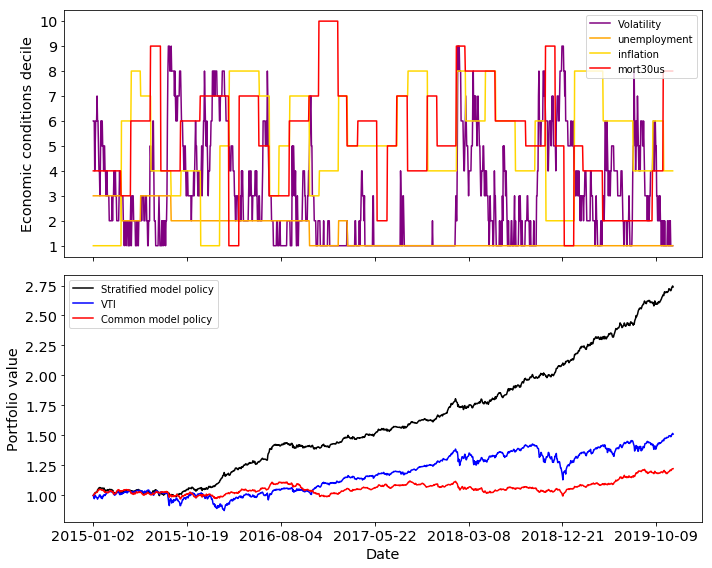

In [15]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)

mapping = {"vix":"Volatility", "unemp":"Unemployment", "inf":"Inflation", "mort":"Mortgage"}
df_Zs = df_Zs.rename(columns=mapping)

(1+df_Zs).plot(ax=ax[0], color=["purple", "orange", "gold", "red"], fontsize="x-large",
              yticks=range(1,11))

VALS = VALS.rename(columns={"benchmark":"VTI"})
VALS.plot(ax=ax[1], color=["black", "blue", "red"], fontsize="x-large")

ax[0].set_xlabel("Date", fontsize="x-large")
ax[0].set_ylabel("Economic conditions decile", fontsize="x-large")
ax[1].set_xlabel("Date", fontsize="x-large")
ax[1].set_ylabel("Portfolio value", fontsize="x-large")

plt.tight_layout()
plt.show()

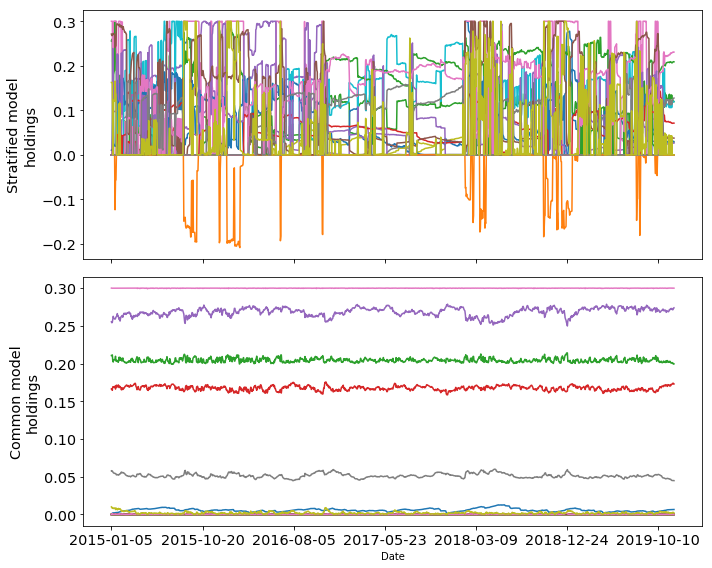

In [16]:
fig, ax = plt.subplots(2,1,figsize=(10,8), sharex=True)

W[0] = W[0].reshape(-1,1)
Wcommon[0] = Wcommon[0].reshape(-1,1)

pd.DataFrame(np.hstack(W).T[1:,:], index=VALS.index[1:]).plot(ax=ax[0], fontsize="x-large", legend=False)
pd.DataFrame(np.hstack(Wcommon).T[1:,:], index=VALS.index[1:]).plot(ax=ax[1], fontsize="x-large", legend=False)

ax[0].set_ylabel("Stratified model\nholdings", fontsize="x-large")
ax[1].set_ylabel("Common model\nholdings", fontsize="x-large")

plt.tight_layout()
plt.show()

In [17]:
def annualized_return_risk(vals):
    
    vals = vals.pct_change()
    P = 250

    ann_return = vals.mean()*P
    ann_risk = vals.std()*np.sqrt(P)
    
    return ann_return, ann_risk

ret_sm, risk_sm = annualized_return_risk(vals=VALS["Stratified model policy"])
ret_common, risk_common = annualized_return_risk(vals=VALS["Common model policy"])
ret_bmark, risk_bmark = annualized_return_risk(vals=VALS["VTI"])

portfolio_returns = VALS.pct_change().dropna()
alphas = portfolio_returns.subtract(portfolio_returns["VTI"],axis=0)
IR = np.sqrt(250)*alphas.mean() / alphas.std()


print("\t\tANNUALIZED")
print("\t\tRETURN          RISK               SHARPE        IR")
print("Stratified\nmodel:")
print("\t", ret_sm, risk_sm, ret_sm/risk_sm, IR["Stratified model policy"])
print("Common\nmodel:")
print("\t", ret_common, risk_common, ret_common/risk_common, IR["Common model policy"])
print("Benchmark:")
print("\t", ret_bmark, risk_bmark, ret_bmark/risk_bmark, 0)

		ANNUALIZED
		RETURN          RISK               SHARPE        IR
Stratified
model:
	 0.20694849771543022 0.0793874491663823 2.6068163152805446 0.8789351451019619
Common
model:
	 0.04358226604126388 0.0753782650668889 0.5781808058674475 -0.42996188088019516
Benchmark:
	 0.09268139987806095 0.13559258892582068 0.6835285070688092 0


In [18]:
fs = ["mktrf", "smb", "hml", "umd"]
factors = pd.read_csv("fama_french_factors.csv", index_col="date")
factors.index = pd.to_datetime(factors.index)
factors["alpha"] = 1
Y = VALS["Stratified model policy"].pct_change().dropna()
Y.index = pd.to_datetime(Y.index)
X = factors.loc[Y.index,fs+["alpha"]]

strat_ff = np.linalg.inv(X.T@X)@X.T@Y
strat_ff = pd.DataFrame(strat_ff.values.reshape(1,-1), columns=fs+["alpha"], index=["Stratified model policy"]).T

factors = pd.read_csv("fama_french_factors.csv", index_col="date")
factors.index = pd.to_datetime(factors.index)
factors["alpha"] = 1
Y = VALS["Common model policy"].pct_change().dropna()
Y.index = pd.to_datetime(Y.index)
X = factors.loc[Y.index,fs+["alpha"]]

common_ff = np.linalg.inv(X.T@X)@X.T@Y
common_ff = pd.DataFrame(common_ff.values.reshape(1,-1), columns=fs+["alpha"], index=["Common model policy"]).T

factors = pd.read_csv("fama_french_factors.csv", index_col="date")
factors.index = pd.to_datetime(factors.index)
factors["alpha"] = 1
Y = VALS["VTI"].pct_change().dropna()
Y.index = pd.to_datetime(Y.index)
X = factors.loc[Y.index,fs+["alpha"]]

bmark_ff = np.linalg.inv(X.T@X)@X.T@Y
bmark_ff = pd.DataFrame(bmark_ff.values.reshape(1,-1), columns=fs+["alpha"], index=["VTI"]).T

ff_table = pd.concat([strat_ff, common_ff, bmark_ff], axis=1)
print(ff_table)

       Stratified model policy  Common model policy       VTI
mktrf                 0.197267             0.266941  0.981221
smb                   0.053690            -0.043335 -0.021237
hml                  -0.034699            -0.354338 -0.004541
umd                  -0.009833            -0.045974  0.000217
alpha                 0.000745            -0.000001 -0.000042
